# Test current version of the package

In [1]:
# Import some useful packages
import xarray as xr
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import marineHeatWaves as mhws
import numpy as np

## Set read and write paths

In [2]:
# path to all post-processed (pp) data
rootdir = ('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'+
           'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/'+
           'pp/')
# specific pp directory
ppname = 'ocean_daily_1x1deg'
# local directory
localdir = '/ts/daily/5yr/'
# Now specify the name of the file you want to open
# NOTE that the filenames always start with the same ppname,
# so I can save some hassle here...
# Use wildcards to grab the years 101 - 200
filename = ppname +'.01[0123456789][16]0101-0[12][0123456789][50]1231.tos.nc'

In [3]:
# The combination of all these defines the path
path = rootdir+ppname+localdir+filename

## Import data

In [4]:
# Load the file using xarray
# For memory reasons, we are going to "chunk" the data in the time dimension
ds = xr.open_mfdataset(path,use_cftime=True,combine='by_coords',engine='netcdf4',
                       drop_variables=['average_DT', 'average_T1', 'average_T2']).chunk({'time':365})

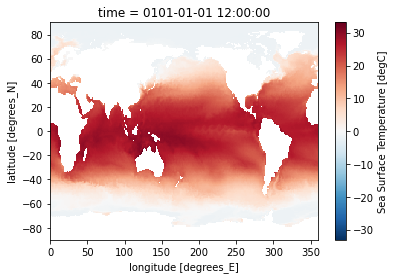

In [5]:
ds['tos'].isel(time=0).plot()
plt.show()

### Subset data
Select a single latitude and longitude (note that we are doing this with the "nominal" coordinate here, so it is not 100% accurate for that location (see discussion in the plotting geodata tutorial). However, it is good enough for our purposes.  

We will also load/compute the data into memory here, which may take several minutes.

In [6]:
# Pick a spot in the Atlantic, on the equator
temp = ds['tos'].sel(lon=340,lat=0,method='nearest')
with ProgressBar():
    temp = temp.compute()

[########################################] | 100% Completed | 36.0s


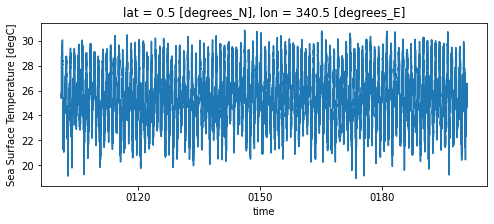

In [7]:
# Quick check of what the time-series looks like
temp.plot(figsize=(8,3))
plt.show()

## Start testing pkg code

In [8]:
mhw, clim = mhws.detect(temp)

## Test output for consistancy

In [9]:
mhw.keys()

dict_keys(['time_start', 'time_end', 'time_peak', 'date_start', 'date_end', 'date_peak', 'index_start', 'index_end', 'index_peak', 'duration', 'duration_moderate', 'duration_strong', 'duration_severe', 'duration_extreme', 'intensity_max', 'intensity_mean', 'intensity_var', 'intensity_cumulative', 'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 'intensity_cumulative_relThresh', 'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', 'intensity_cumulative_abs', 'category', 'rate_onset', 'rate_decline', 'n_events'])

In [10]:
mhw['n_events']

304

In [11]:
eva = np.arange(1,mhw['n_events']+1) # Create an array of indices for the events
xm = xr.Dataset(coords={'ev':eva})
for key,value in mhw.items():
    key
    xm[key]=xr.DataArray(value,dims=['ev'],coords={'ev':eva})
# Don't need to keep the 'n_events' variable
xm = xm.drop('n_events')

In [12]:
# Now we can take a look at that 
xm

<xarray.Dataset>
Dimensions:                         (ev: 304)
Coordinates:
  * ev                              (ev) int64 1 2 3 4 5 ... 300 301 302 303 304
Data variables: (12/29)
    time_start                      (ev) int64 36534 36600 36738 ... 72604 72689
    time_end                        (ev) int64 36538 36610 36742 ... 72611 72698
    time_peak                       (ev) int64 36536 36606 36740 ... 72608 72694
    date_start                      (ev) object 0101-02-04 12:00:00 ... 0200-...
    date_end                        (ev) object 0101-02-08 12:00:00 ... 0200-...
    date_peak                       (ev) object 0101-02-06 12:00:00 ... 0200-...
    ...                              ...
    intensity_mean_abs              (ev) float32 28.65 29.85 ... 26.95 29.69
    intensity_var_abs               (ev) float32 0.135 0.2038 ... 0.1321 0.1587
    intensity_cumulative_abs        (ev) float32 143.3 328.3 ... 215.6 296.9
    category                        (ev) <U8 'Moderate' ... 'Moderate'
    rate_onset                      (ev) float64 0.1585 0.1045 ... 0.09101
    rate_decline                    (ev) float64 0.1643 0.1581 ... 0.09439

In [13]:
# Do the same for the climatology
xc = xr.Dataset(coords={'time':temp['time']})
for key,value in clim.items():
    xc[key]=xr.DataArray(value,dims=['time'],coords={'time':temp['time']})

In [14]:
xc

<xarray.Dataset>
Dimensions:  (time: 36500)
Coordinates:
    lat      float64 0.5
    lon      float64 340.5
  * time     (time) object 0101-01-01 12:00:00 ... 0200-12-31 12:00:00
Data variables:
    thresh   (time) float64 26.69 26.71 26.73 26.76 ... 26.6 26.62 26.64 26.67
    seas     (time) float64 25.79 25.8 25.81 25.83 ... 25.77 25.77 25.78 25.78
    missing  (time) bool False False False False ... False False False False

In [15]:
evmax = xm['intensity_cumulative'].argmax(dim='ev') # Find largest event
# Select this extreme event
ex = xm.isel(ev=evmax)
# Print some of its attributes
print('Maximum intensity:', ex['intensity_max'].values, 'deg. C')
print('Average intensity:', ex['intensity_mean'].values, 'deg. C')
print('Cumulative intensity:', ex['intensity_cumulative'].values, 'deg. C-days')
print('Duration:', ex['duration'].values, 'days')
# Note that if we want the date, we have to grab it from the original time array using the 
# index returned by the package (rather than using the date_start/end attributes)
das = temp['time'].isel(time=ex['index_start'])
print('Start date:', das.values)
dae = temp['time'].isel(time=ex['index_end'])
print('End date:', dae.values)

### Just to check, take a look at the difference in dates output by marineHeatWaves
print(' ')
print('Note there no longer is a difference in dates derived in marineHeatWaves:')
print('Start date:', mhw['date_start'][int(evmax)].strftime("%d %B %Y"))
print('End date:', mhw['date_end'][int(evmax)].strftime("%d %B %Y"))

Maximum intensity: 2.5690576491817367 deg. C
Average intensity: 2.087910238559955 deg. C
Cumulative intensity: 75.16476858815838 deg. C-days
Duration: 36 days
Start date: 0113-05-17 12:00:00
End date: 0113-06-21 12:00:00
 
Note there no longer is a difference in dates derived in marineHeatWaves:
Start date: 17 May 0113
End date: 21 June 0113


### Now let's plot some data

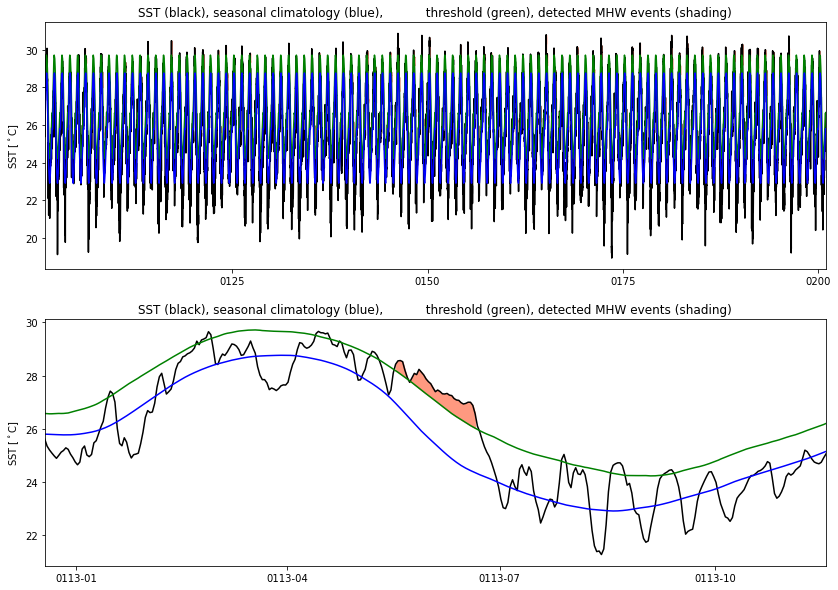

In [16]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(temp['time'], temp, 'k-')
plt.plot(xc['time'], xc['thresh'], 'g-')
plt.plot(xc['time'], xc['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel(r'SST [$^\circ$C]')
# Find indices for all MHWs and shade accordingly
for evnow in range(len(xm['ev'])):
    # Get the attributes for the event
    xmnow = xm.isel(ev=evnow)
    i1 = int(xmnow['index_start'])
    i2 = int(xmnow['index_end'])
    # Select the temperature timeseries and the climatology during the event
    tos_ev = temp.isel(time=slice(i1,i2))
    xc_ev = xc.isel(time=slice(i1,i2))
    # Shade between these lines using the .fill_between function
    plt.fill_between(tos_ev['time'].values, tos_ev, xc_ev['thresh'], \
                     color=(1,0.6,0.5))

# Now zoom in on the most extreme event
plt.subplot(2,1,2) # Add a subplot
# Get the event index
evnow = evmax

# As above, Get the attributes for the event
xmnow = xm.isel(ev=evnow)
i1 = int(xmnow['index_start'])
i2 = int(xmnow['index_end'])
# Select the temperature timeseries and the climatology during the event
tos_ev = temp.isel(time=slice(i1,i2))
xc_ev = xc.isel(time=slice(i1,i2))
# Shade between these lines using the .fill_between function
plt.fill_between(tos_ev['time'].values, tos_ev, xc_ev['thresh'], \
                 color=(1,0.6,0.5))
# Now get the temperature and climatology for a time period of ~1 year **around** the event
# And plot them
tos_evplus = temp.isel(time=slice(i1-150,i2+150))
xc_evplus = xc.isel(time=slice(i1-150,i2+150))
plt.plot(tos_evplus['time'], tos_evplus, 'k-')
plt.plot(xc_evplus['time'], xc_evplus['thresh'], 'g-')
plt.plot(xc_evplus['time'], xc_evplus['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.ylabel(r'SST [$^\circ$C]')
plt.autoscale(enable=True, axis='x', tight=True)